In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [129]:
raw_data = pd.read_csv("tempos.csv")
data = raw_data[raw_data['Deslocado'] == False].copy()

for row in data.index.values:
    try:
        t1 = data.at[row, 'Tempo']
        t2 = data.at[row + 1, 'Tempo']
        data.at[row, 'Tempo'] = ((t1 + t2)/2)
        data = data.drop(row + 1)
        pass
    except:
        continue      
    
data = pd.concat([data, raw_data[raw_data['Deslocado'] == True]])

In [130]:
def MRU(v, S, label):
    t = 0 
    Ts = []    
    for i in range(len(S)):
        t = S[i]/v        
        Ts.append(t)  

    plt.title('Média ' + label)    
    plt.plot(S, Ts)
    plt.axis([0, 30, 0, 100])
    plt.show()
    
def plot(s, t, label):
    plt.plot(s, t)
    plt.axis([0, 30, 0, 50])
    plt.title(label)
    plt.show()
#print(data)
velocidades_medias = []

0.5161111111111111 m/s


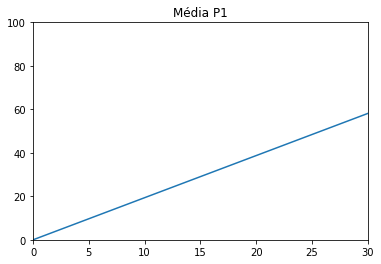

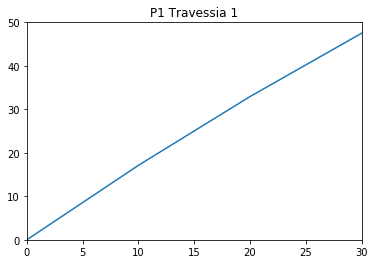

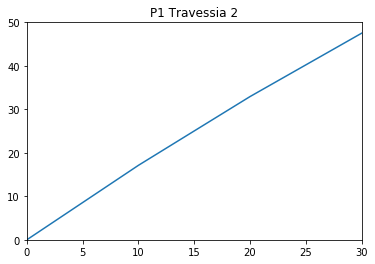

In [131]:
#Analise dos dados para primeira pessoa S = So + Vt
data_P1 = data[data['Pessoa']=='P1'].copy()
data_P1_MRU = data_P1[data_P1['Tipo']=='MRU'].copy()
data_P1_MRU = data_P1_MRU[data_P1_MRU['Deslocado']==False].copy()
tm_P1_MRU = data_P1_MRU['Tempo'].mean()

# calculo da velocidade média da pessoa 1
vm_P1_MRU = tm_P1_MRU/60
print(str(vm_P1_MRU) + ' m/s')
velocidades_medias.append(vm_P1_MRU)  #adicionando velocidade média para calculo 
snd = [0, 10, 20, 30]                 #espaço não deslocado
sd = [0, 5, 10, 25, 20, 30]           #espaço deslocado
MRU(vm_P1_MRU, snd, 'P1')

# Plotar travessias 1 e 2
data_T1 = data_P1_MRU[data_P1_MRU['Travessia']=='T1']
data_T2 = data_P1_MRU[data_P1_MRU['Travessia']=='T2']
tempos_T1 = data_T1.loc[:, 'Tempo'].values
tempos_T2 = data_T1.loc[:, 'Tempo'].values
tempos_T1 = np.concatenate(([0],tempos_T1), axis=0)
tempos_T2 = np.concatenate(([0],tempos_T2), axis=0)

plot(snd, tempos_T1, 'P1 Travessia 1')
plot(snd, tempos_T2, 'P1 Travessia 2')

0.3667083333333333 m/s


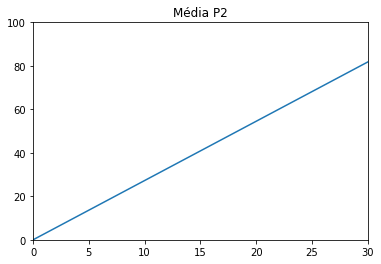

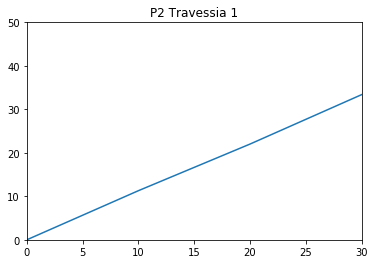

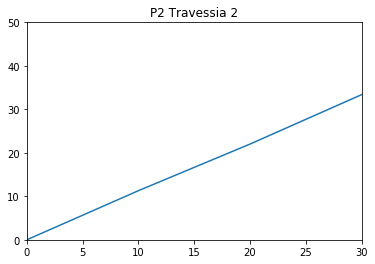

In [132]:

data_P2 = data[data['Pessoa']=='P2'].copy()
data_P2_MRU = data_P2[data_P2['Tipo']=='MRU'].copy()
data_P2_MRU = data_P2_MRU[data_P2_MRU['Deslocado']==False].copy()
tm_P2_MRU = data_P2_MRU['Tempo'].mean()

# calculo da velocidade média da pessoa 2
vm_P2_MRU = tm_P2_MRU/60
print(str(vm_P2_MRU) + ' m/s')
velocidades_medias.append(vm_P2_MRU)  #adicionando velocidade média para calculo 
snd = [0, 10, 20, 30]                 #espaço não deslocado
sd = [0, 5, 10, 25, 20, 30]           #espaço deslocado
MRU(vm_P2_MRU, snd, 'P2')

# Plotar travessias 1 e 2
data_T1 = data_P2_MRU[data_P2_MRU['Travessia']=='T1']
data_T2 = data_P2_MRU[data_P2_MRU['Travessia']=='T2']
tempos_T1 = data_T1.loc[:, 'Tempo'].values
tempos_T2 = data_T1.loc[:, 'Tempo'].values
tempos_T1 = np.concatenate(([0],tempos_T1), axis=0)
tempos_T2 = np.concatenate(([0],tempos_T2), axis=0)

plot(snd, tempos_T1, 'P2 Travessia 1')
plot(snd, tempos_T2, 'P2 Travessia 2')

0.41918055555555556 m/s


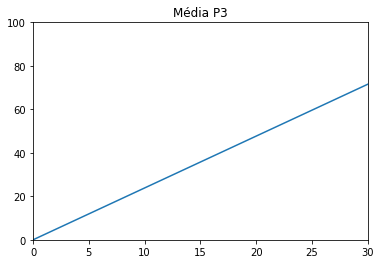

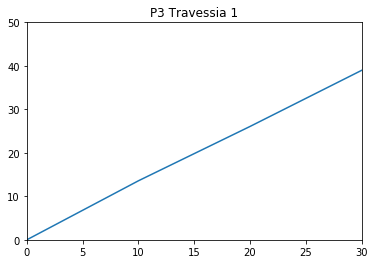

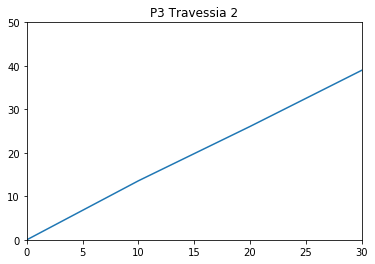

In [133]:
data_P3 = data[data['Pessoa']=='P3'].copy()
data_P3_MRU = data_P3[data_P3['Tipo']=='MRU'].copy()
data_P3_MRU = data_P3_MRU[data_P3_MRU['Deslocado']==False].copy()
tm_P3_MRU = data_P3_MRU['Tempo'].mean()

# calculo da velocidade média da pessoa 3
vm_P3_MRU = tm_P3_MRU/60
print(str(vm_P3_MRU) + ' m/s')
velocidades_medias.append(vm_P3_MRU)  #adicionando velocidade média para calculo 
snd = [0, 10, 20, 30]                 #espaço não deslocado
sd = [0, 5, 10, 25, 20, 30]           #espaço deslocado
MRU(vm_P3_MRU, snd, 'P3')

# Plotar travessias 1 e 2
data_T1 = data_P3_MRU[data_P3_MRU['Travessia']=='T1']
data_T2 = data_P3_MRU[data_P3_MRU['Travessia']=='T2']
tempos_T1 = data_T1.loc[:, 'Tempo'].values
tempos_T2 = data_T1.loc[:, 'Tempo'].values
tempos_T1 = np.concatenate(([0],tempos_T1), axis=0)
tempos_T2 = np.concatenate(([0],tempos_T2), axis=0)

plot(snd, tempos_T1, 'P3 Travessia 1')
plot(snd, tempos_T2, 'P3 Travessia 2')

Média das velocidades de todas as pessoas MRU
0.434 m/s


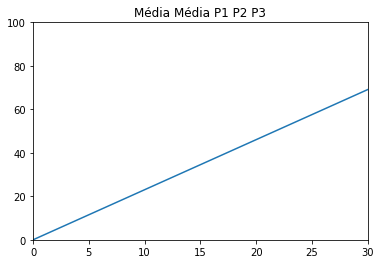

In [134]:
print('Média das velocidades de todas as pessoas MRU')
vm = np.mean(velocidades_medias)
print(str(vm) + ' m/s')
MRU(vm, snd, 'Média P1 P2 P3')
